In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import json

In [ ]:
dir = "../data"

### Load Dataframes

In [295]:
spain = pd.read_csv(dir+"historical_metering_data_ES.csv")
italy = pd.read_csv(dir+"historical_metering_data_IT.csv")

rollout_ES = pd.read_csv(dir+"rollout_data_ES.csv")
rollout_IT = pd.read_csv(dir+"rollout_data_IT.csv")

PV_ES = pd.read_excel(dir+"spv_ec00_forecasts_es_it.xlsx", sheet_name="ES")
PV_IT = pd.read_excel(dir+"spv_ec00_forecasts_es_it.xlsx", sheet_name="IT")

PV_ES.rename(columns={PV_ES.columns[0]: 'DATETIME'}, inplace=True)
PV_IT.rename(columns={PV_IT.columns[0]: 'DATETIME'}, inplace=True)

spain["DATETIME"] = pd.to_datetime(spain["DATETIME"])
italy["DATETIME"] = pd.to_datetime(italy["DATETIME"])
rollout_ES["DATETIME"] = pd.to_datetime(rollout_ES["DATETIME"])
rollout_IT["DATETIME"] = pd.to_datetime(rollout_IT["DATETIME"])

rollout_ES = rollout_ES.set_index("DATETIME").asfreq("H")
rollout_IT = rollout_IT.set_index("DATETIME").asfreq("H")

/var/folders/tk/w4xllgbs0ds2ch4ngj5_n8280000gn/T/ipykernel_14247/662769609.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rollout_ES = rollout_ES.set_index("DATETIME").asfreq("H")
/var/folders/tk/w4xllgbs0ds2ch4ngj5_n8280000gn/T/ipykernel_14247/662769609.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rollout_IT = rollout_IT.set_index("DATETIME").asfreq("H")


In [296]:
spain = pd.merge(spain, PV_ES, on="DATETIME")
italy = pd.merge(italy, PV_IT, on="DATETIME")
spain = spain.set_index('DATETIME').asfreq("H")
italy = italy.set_index("DATETIME").asfreq("H")

/var/folders/tk/w4xllgbs0ds2ch4ngj5_n8280000gn/T/ipykernel_14247/234092624.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  spain = spain.set_index('DATETIME').asfreq("H")
/var/folders/tk/w4xllgbs0ds2ch4ngj5_n8280000gn/T/ipykernel_14247/234092624.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  italy = italy.set_index("DATETIME").asfreq("H")


In [297]:
spain.columns = spain.columns.str.replace('VALUEMWHMETERINGDATA_customerES_', '', regex=False)
italy.columns = italy.columns.str.replace('VALUEMWHMETERINGDATA_customerIT_', '', regex=False)

rollout_ES.columns = rollout_ES.columns.str.replace('INITIALROLLOUTVALUE_customerES_', '', regex=False)
rollout_IT.columns = rollout_IT.columns.str.replace('INITIALROLLOUTVALUE_customerIT_', '', regex=False)

spain['hour'] = spain.index.hour
spain['day_of_week'] = spain.index.dayofweek
italy['hour'] = italy.index.hour
italy['day_of_week'] = italy.index.dayofweek

Remove Daylight Saving (time doesn't exist)

In [298]:
s = spain["1"]
dst = s.index[s.isna()]

In [299]:
dst = ['2022-03-27 02:00:00', '2023-03-26 02:00:00', '2024-03-31 02:00:00']

In [300]:
spain.drop(dst, inplace=True)
italy.drop(dst, inplace=True)
rollout_ES.drop(dst, inplace=True)
rollout_IT.drop(dst, inplace=True)

In [301]:
spain_portfolio_before = spain[spain.columns[:-4]].sum(axis=1)

### Correlation between customers (Spain)

<Axes: >

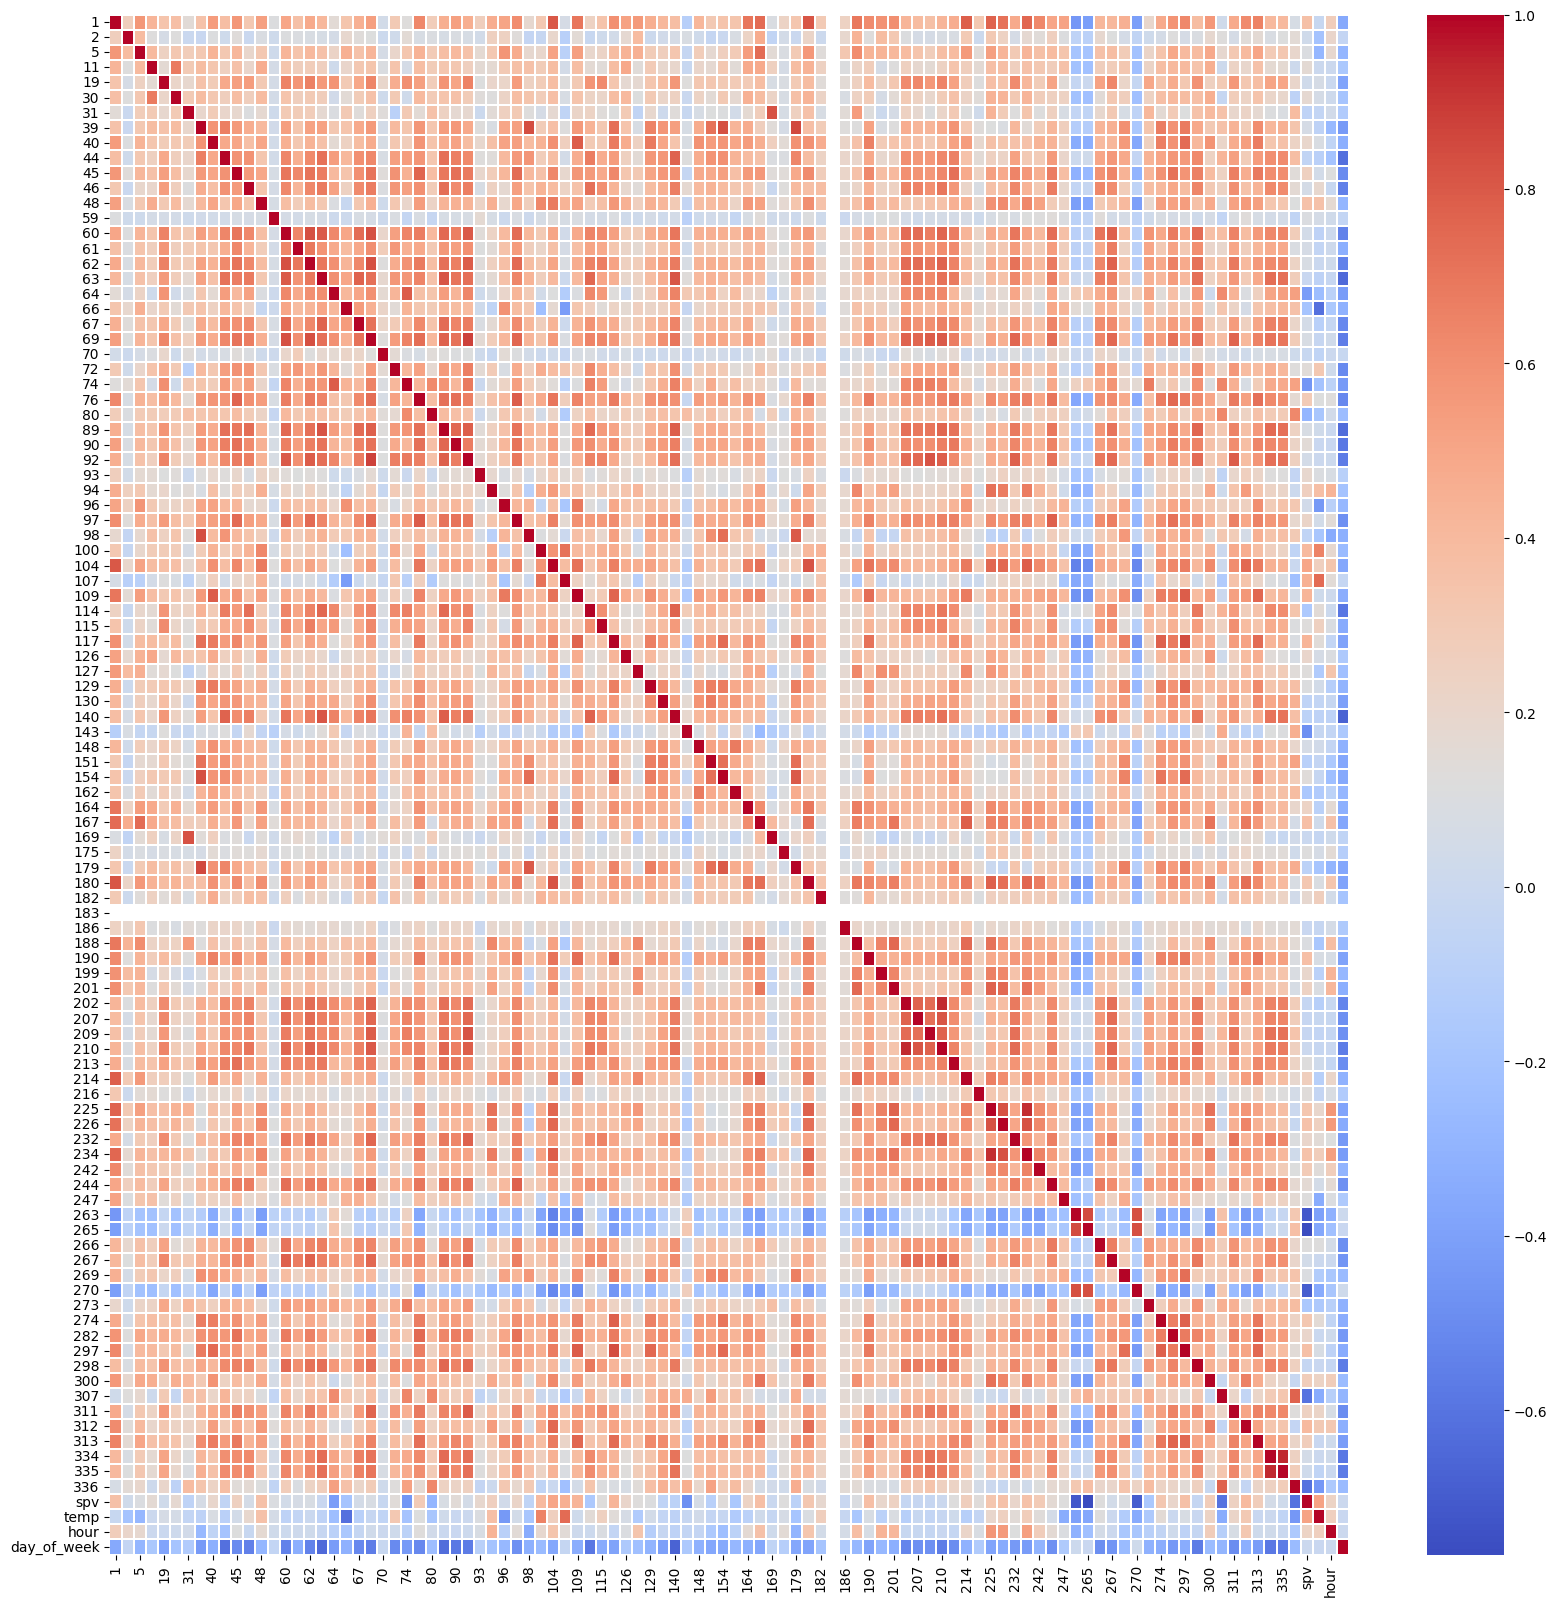

In [307]:
plt.figure(figsize=(20,20))
correlation = spain.corr()
sns.heatmap(correlation, cmap='coolwarm', fmt='.2f', linewidths=0.1)

### SPAIN

One customer is all zeros (small consumer)

In [302]:
list(spain.columns[(spain == 0).all()])

['183']

When did they join Alpiq?

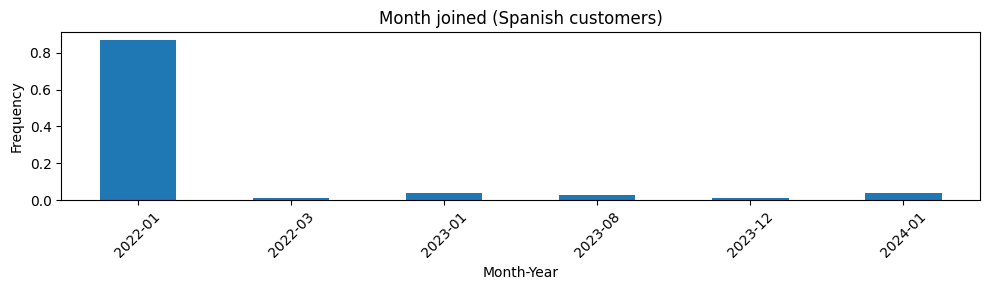

In [303]:
spain_cropped = spain[spain.columns[:-4]]
first_valid_indices = spain_cropped.apply(lambda col: col.first_valid_index())
first_valid_month_year = first_valid_indices.dt.to_period('M')
month_year_counts = first_valid_month_year.value_counts().sort_index()
normalized_counts = month_year_counts / len(spain_cropped.columns)

plt.figure(figsize=(10, 3))
normalized_counts.plot(kind='bar')
plt.xlabel('Month-Year')
plt.ylabel('Frequency')
plt.title('Month joined (Spanish customers)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Find NaNs: customers who joined after May 2023

In [304]:
to_impute_ES = []
for col in spain.columns[:-4]:
    first = spain[col].first_valid_index()
    if first > pd.Timestamp('2023-05-01'):
        to_impute_ES.append(col)

Find who the late joiners are correlated with

In [308]:
correlated_ES = []
correlations_ES =[]
for col in to_impute_ES:
    correlated_ES.append(correlation[col].nlargest(2).idxmin())
    correlations_ES.append(correlation[col].nlargest(2).iloc[-1])

In [309]:
print(to_impute_ES, correlated_ES)

['72', '74', '167', '186', '244', '266', '307', '336'] ['92', '64', '214', '5', '97', '60', '336', '307']


The last 2 columns are correlated with each other - cant impute them this way

Scale and impute

In [310]:
for idx, col1 in enumerate(to_impute_ES[:-2]):
    col_impute_1 = correlated_ES[idx]
    scaler = StandardScaler()
    mean, std = spain[col1].mean(), spain[col1].std()
    arr1 = scaler.fit_transform(spain[[col1]])
    arr2 = scaler.fit_transform(spain[[col_impute_1]])
    arr1 = arr1.reshape(len(arr1))
    arr2 = arr2.reshape(len(arr2))
    arr1[np.isnan(arr1)] = arr2[np.isnan(arr1)]
    spain[col1] = arr1 * std + mean


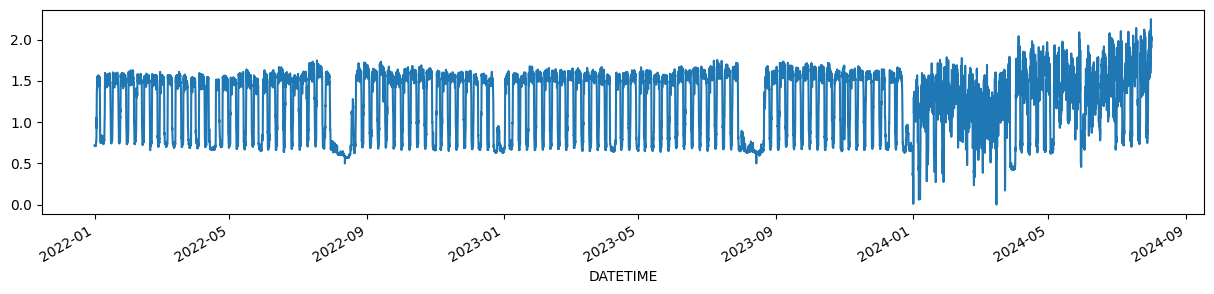

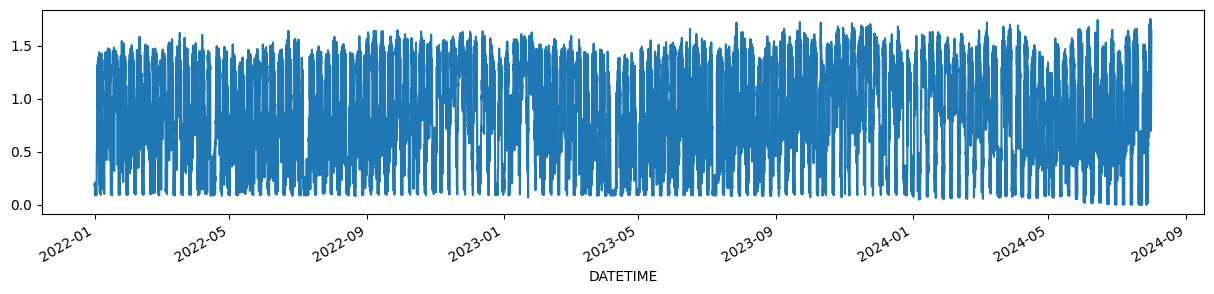

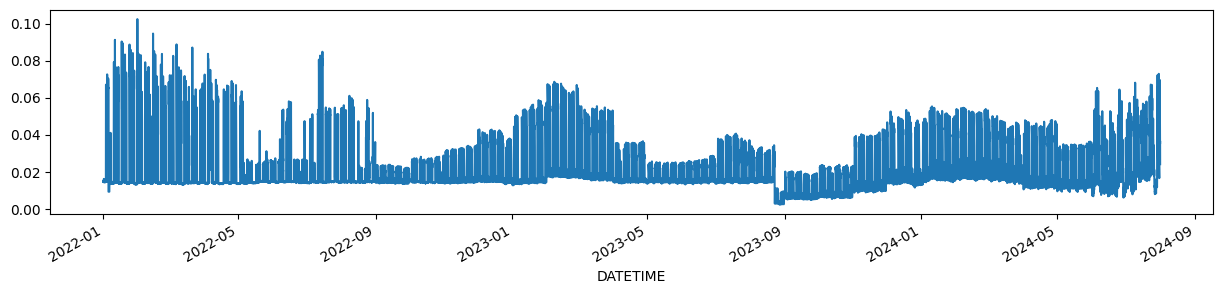

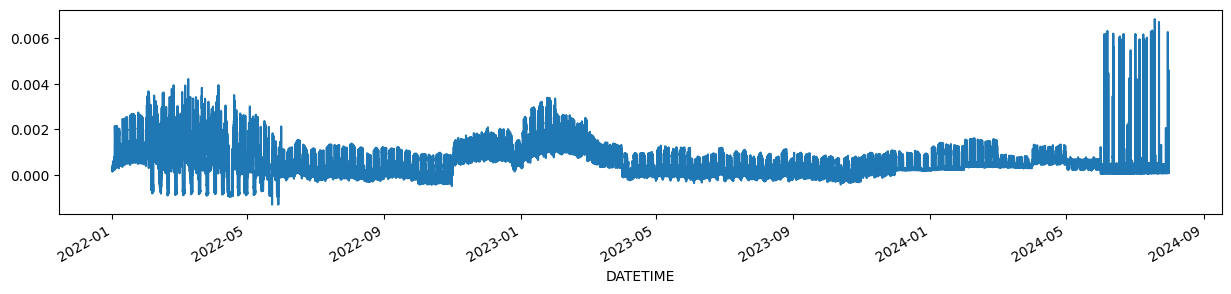

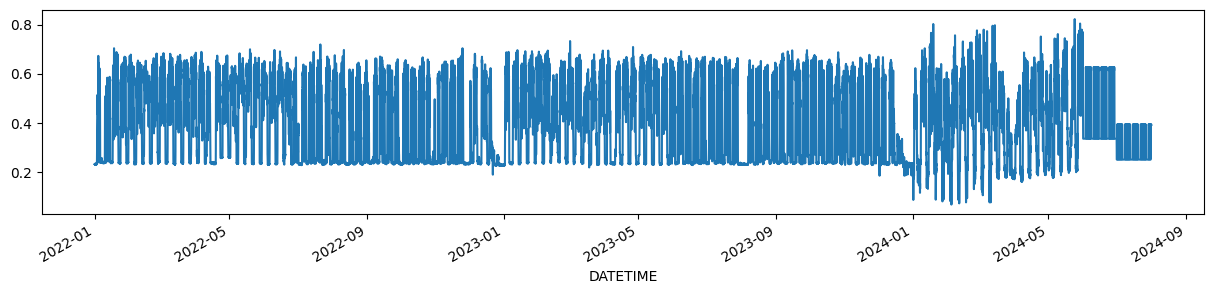

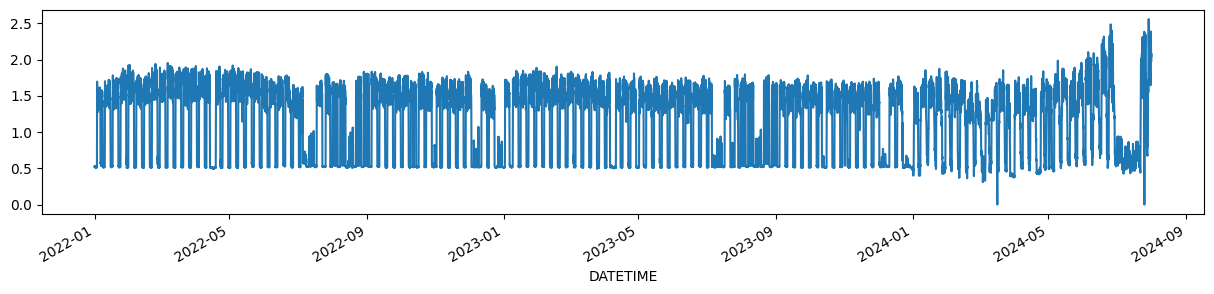

In [311]:
for col in to_impute_ES[:-2]:
    plt.figure(figsize=(15,3))
    spain[col].plot()

For the last 2 columns, just replace past data with future data of corresponding datetime
(They are found to be fairly regular)

In [312]:
for idx in [-2, -1]:
    s = spain[to_impute_ES[idx]]
    s_imputed = s.copy()

    for ts in s[s.isna()].index:
        try:
            target_year = ts.year + 2
            target_ts = ts.replace(year=target_year)
            
            if target_ts in s.index and pd.notna(s[target_ts]):
                s_imputed[ts] = s[target_ts]
            else:
                target_ts = ts.replace(year=ts.year + 1)
                if target_ts in s.index and pd.notna(s[target_ts]):
                    s_imputed[ts] = s[target_ts]
        except:
            continue
    
    spain[to_impute_ES[idx]] = s_imputed

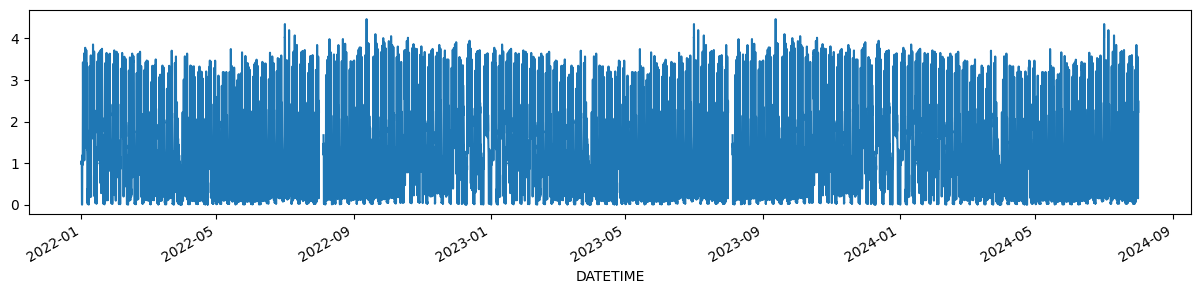

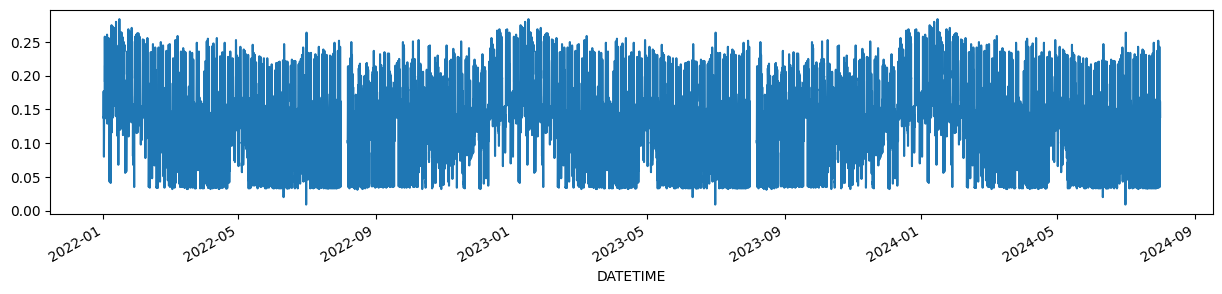

In [313]:
plt.figure(figsize=(15, 3))
spain[to_impute_ES[-2]].plot()
plt.show()
plt.figure(figsize=(15, 3))
spain[to_impute_ES[-1]].plot()
plt.show()

In [314]:
spain_portfolio = spain[spain.columns[:-4]].sum(axis=1)

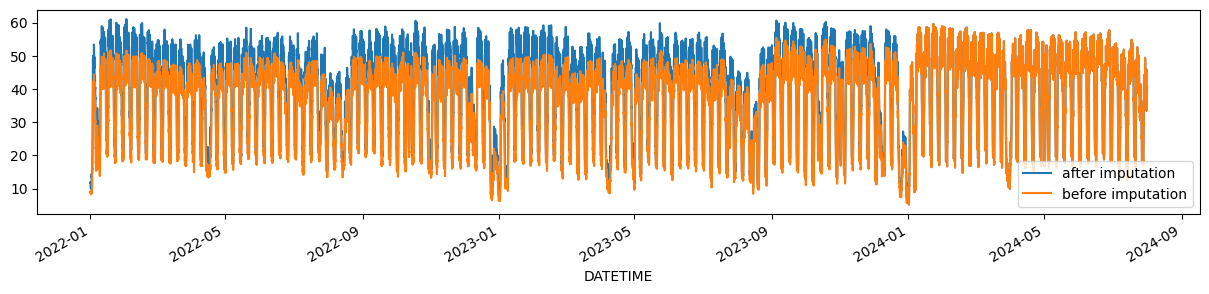

In [284]:
plt.figure(figsize=(15, 3))
spain_portfolio.plot(label="after imputation")
spain_portfolio_before.plot(label="before imputation")
plt.legend()
plt.show()

### ITALY

Find NaN values

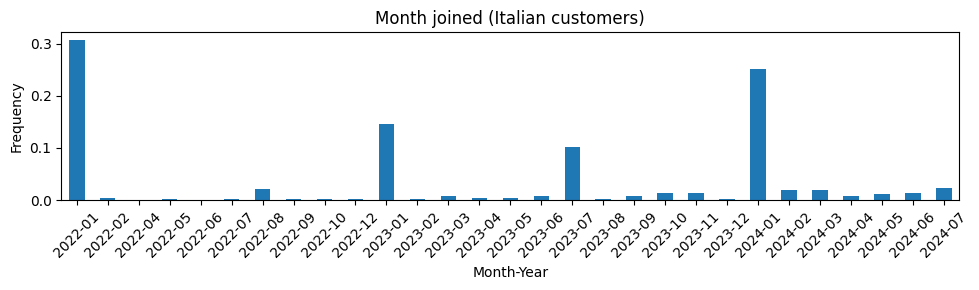

In [155]:
italy_cropped = italy[italy.columns[:-4]]
first_valid_indices = italy_cropped.apply(lambda col: col.first_valid_index())
first_valid_month_year = first_valid_indices.dt.to_period('M')
month_year_counts = first_valid_month_year.value_counts().sort_index()
normalized_counts = month_year_counts / len(italy_cropped.columns)

plt.figure(figsize=(10, 3))
normalized_counts.plot(kind='bar')
plt.xlabel('Month-Year')
plt.ylabel('Frequency')
plt.title('Month joined (Italian customers)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


There is growth in the portfolio values at Jan 23, July 23 and Jan 24 as a result of new customers

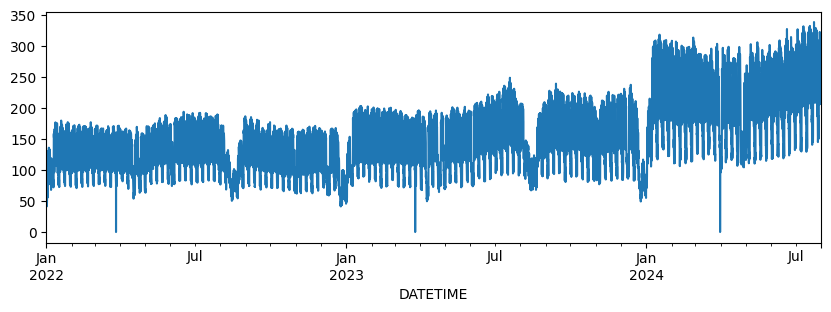

In [182]:
italy_portfolio = italy[italy.columns[:-4]].sum(axis=1)

plt.figure(figsize=(10,3))
italy_portfolio.plot()
plt.show()

Columns with all NaNs/zeros

In [157]:
allzeros = list(italy.columns[(italy.isna() | (italy == 0)).all()])
italy.drop(allzeros, axis=1, inplace=True)

In [24]:
# save customer IDs with all zeros
zeros_ESIT = {"ES": ['183'], "IT": allzeros}
with open('zeros.json', 'w') as f:
    json.dump(zeros_ESIT, f)

### Correlation between Rollout and Consumption: Spain

Find percentage of customers with high correlation between rollout and consumption

In [321]:
corr_rollout_ES = rollout_ES.corrwith(spain.iloc[:, :-4])
print((corr_rollout_ES > 0.6).sum()/len(corr_rollout_ES))

0.24489795918367346


Use the sum of rollouts of the highly correlated customers as a feature for the portfolio

In [322]:
high_rolloutcorr_ES = corr_rollout_ES > 0.6
high_rolloutcorr_ES = high_rolloutcorr_ES[high_rolloutcorr_ES].index.tolist()

1/3 of Spanish high-correlation customers only started giving rollouts in 2023

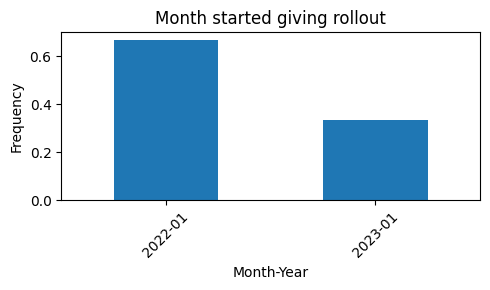

In [323]:
first_valid_indices = rollout_ES[high_rolloutcorr_ES].apply(lambda col: col.first_valid_index())
first_valid_month_year = first_valid_indices.dt.to_period('M')
month_year_counts = first_valid_month_year.value_counts().sort_index()
normalized_counts = month_year_counts / len(first_valid_indices)

plt.figure(figsize=(5, 3))
normalized_counts.plot(kind='bar')
plt.xlabel('Month-Year')
plt.ylabel('Frequency')
plt.title('Month started giving rollout')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Exclude these late-givers for now

In [324]:
ser1 = first_valid_indices < pd.Timestamp('2022-02-01')
high_rolloutcorr_ES = ser1[ser1].index
high_rolloutcorr_ES = rollout_ES[high_rolloutcorr_ES].sum(axis=1)

<Axes: xlabel='DATETIME'>

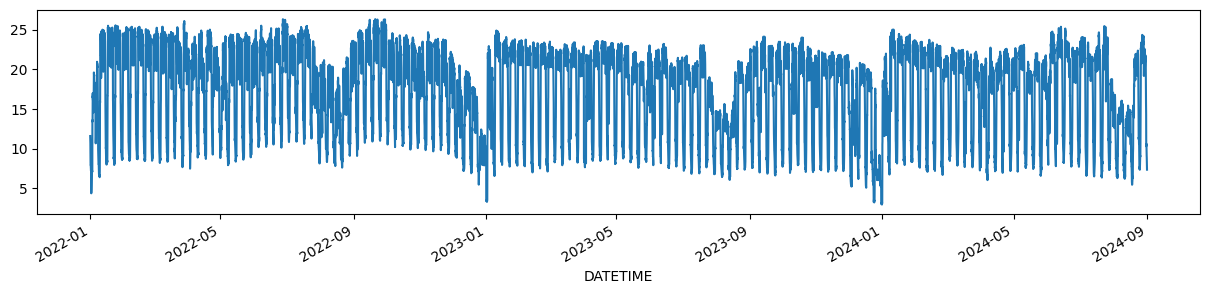

In [325]:
plt.figure(figsize=(15,3))
high_rolloutcorr_ES.plot()

In [ ]:
# high_rolloutcorr_ES.to_csv("highcorr_rollout_v2_ES.csv")

#### Assign weights manually according to time of the year
Behaviour between mid-December and mid-January similar to August

ITALY

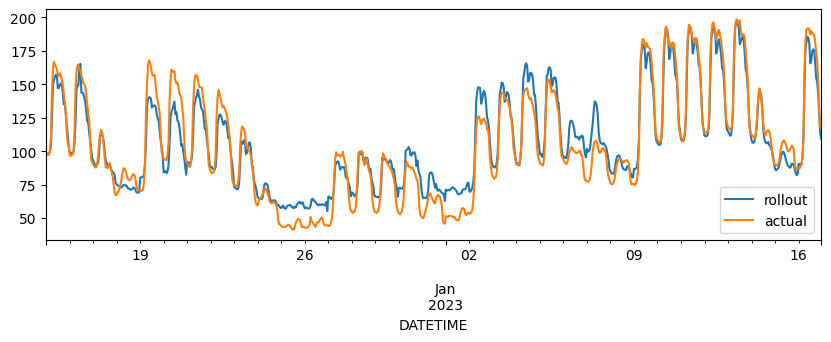

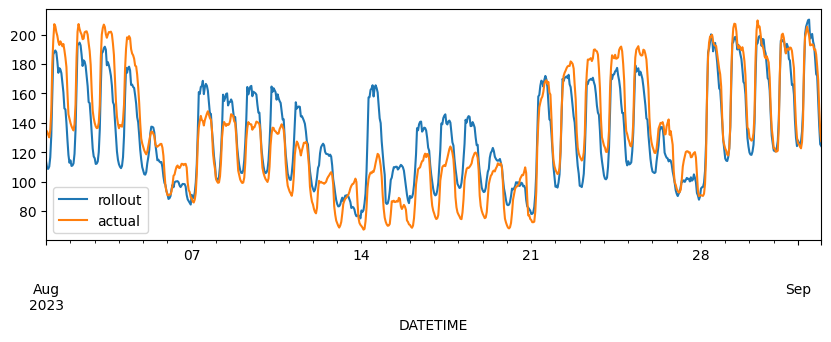

In [244]:
plt.figure(figsize=(10,3))
rollout_IT.sum(axis=1).loc['2022-12-15':'2023-01-16'].plot(label="rollout")
italy_portfolio.loc['2022-12-15':'2023-01-16'].plot(label="actual")
plt.legend()

plt.figure(figsize=(10,3))
rollout_IT.sum(axis=1).loc['2023-08-01':'2023-09-01'].plot(label="rollout")
italy_portfolio.loc['2023-08-01':'2023-09-01'].plot(label="actual")
plt.legend()

SPAIN

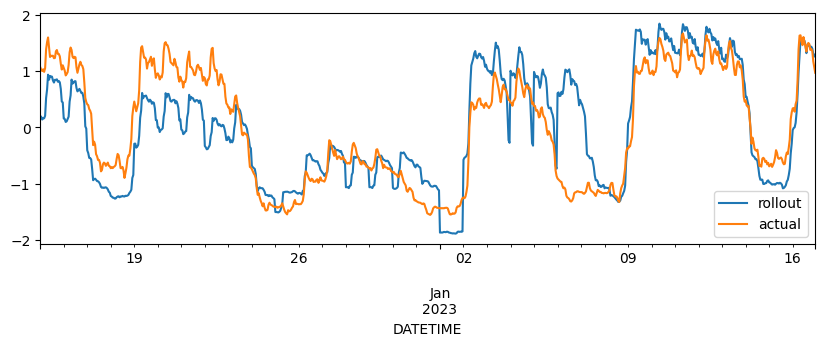

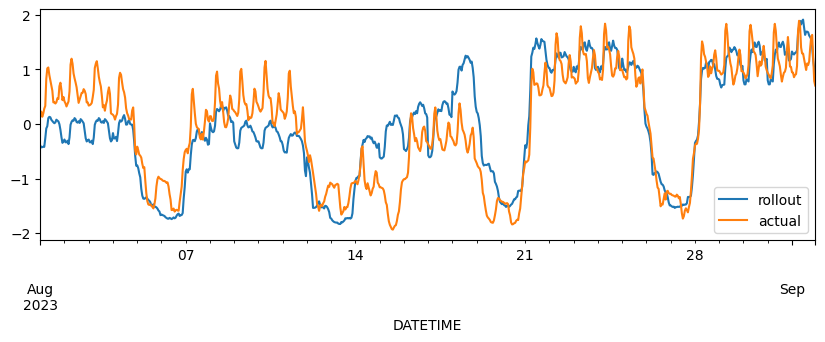

In [332]:
ser1 = high_rolloutcorr_ES.loc['2022-12-15':'2023-01-16']
ser1 = (ser1 - ser1.mean()) / ser1.std()
ser2 = spain_portfolio.loc['2022-12-15':'2023-01-16']
ser2 = (ser2 - ser2.mean()) / ser2.std()
plt.figure(figsize=(10,3))
ser1.plot(label="rollout")
ser2.plot(label="actual")
plt.legend()

ser1 = high_rolloutcorr_ES.loc['2023-08-01':'2023-09-01']
ser1 = (ser1 - ser1.mean()) / ser1.std()
ser2 = spain_portfolio.loc['2023-08-01':'2023-09-01']
ser2 = (ser2 - ser2.mean()) / ser2.std()
plt.figure(figsize=(10,3))
ser1.plot(label="rollout")
ser2.plot(label="actual")
plt.legend()

In [264]:
def make_weight(datetime, a=10, b=7):
    weights = pd.DataFrame({
        'DATETIME': datetime,
        'WEIGHT': 1
    })

    weights.loc[(weights['DATETIME'] >= '2022-12-15') & (weights['DATETIME'] < '2023-01-16'), 'WEIGHT'] = a
    weights.loc[(weights['DATETIME'] >= '2022-08-01') & (weights['DATETIME'] < '2022-09-01'), 'WEIGHT'] = a
    weights.loc[(weights['DATETIME'] >= '2023-12-15') & (weights['DATETIME'] < '2024-01-16'), 'WEIGHT'] = a
    weights.loc[(weights['DATETIME'] >= '2023-08-01') & (weights['DATETIME'] < '2023-09-01'), 'WEIGHT'] = a
    weights.loc[(weights['DATETIME'] >= '2022-05-01') & (weights['DATETIME'] < '2022-08-01'), 'WEIGHT'] = b
    weights.loc[(weights['DATETIME'] >= '2023-05-01') & (weights['DATETIME'] < '2023-08-01'), 'WEIGHT'] = b
    weights.loc[(weights['DATETIME'] >= '2024-05-01') & (weights['DATETIME'] < '2024-08-01'), 'WEIGHT'] = b

    return weights

